# Semantic Spotter - Build a RAG System


The goal of the project will be to build a robust generative search system capable of effectively and accurately answering questions from various insurance policy documents using llamaindex.


## Part 0 - Quick Recap of RAG

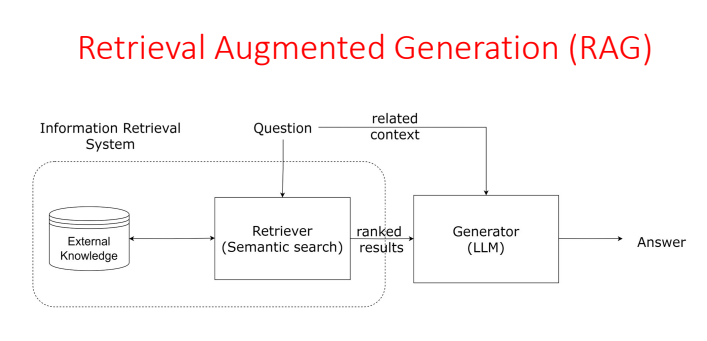

Without RAG: LLM's don't have any information on the domain/enterprise specific query.
With RAG: We are connecting an external data (ingested & transformed - embeddings - semantic search (dot product/cosine similarity) - top k relevant documents) - (context + user query)--> decorated using prompt engineering --> results

### Part 1 - Solution POC

In this section, we go ahead and actually build a POC of the solution that we proposed in the previous step

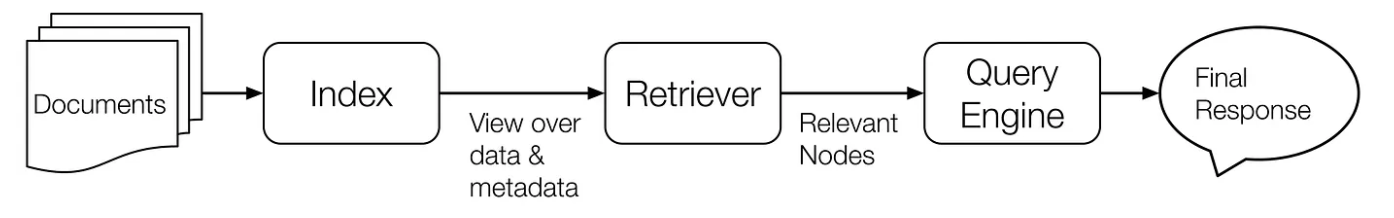

Parser feeds on the document, strides/moves over each content in a step manner.

## Solution Architecture

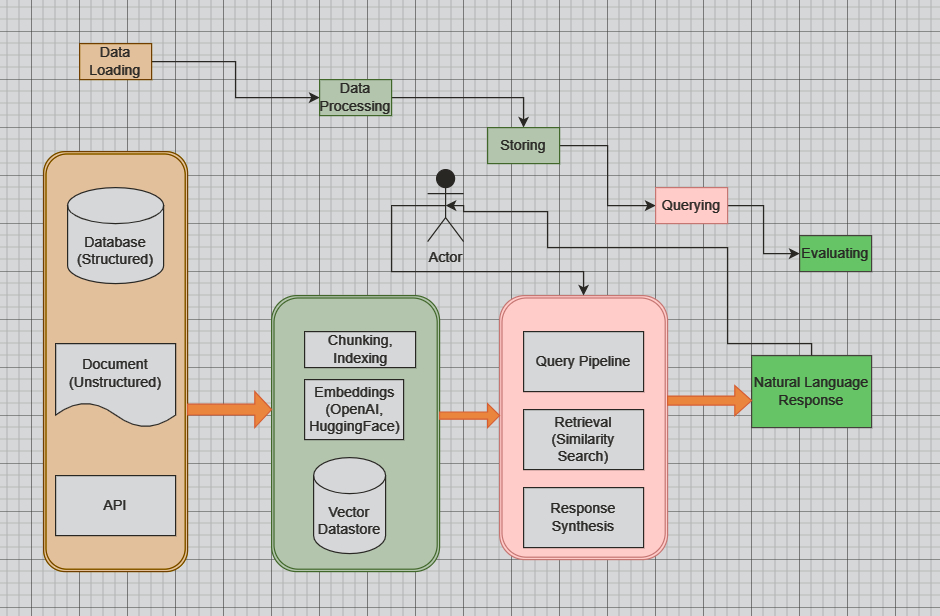

Here's a concise explanation of each RAG architecture component:

**1. Data Sources:**
- Database (Structured): Organized data in tables/schemas (SQL, MongoDB)
- Document (Unstructured): Raw text, PDFs, web pages
- API: Programmatic data access points

**2. Data Processing:**
- Chunking/Indexing: Breaks documents into smaller, manageable segments
- Embeddings: Converts text into vector representations using models like OpenAI/HuggingFace
- Vector Datastore: Stores and indexes embeddings for efficient similarity search (FAISS, Pinecone)

**3. Query Pipeline:**
- Query Processing: Transforms user questions into appropriate search queries
- Retrieval: Finds relevant chunks using similarity search
- Response Synthesis: Generates coherent answers using retrieved context and LLM

**4. Natural Language Response:**
- Final output formatted as human-readable text
- Combines retrieved context with LLM-generated response

**5. Evaluation:**
- Measures response quality, relevance, and accuracy
- Tracks retrieval performance and system metrics

**6. Actor (User) Interaction:**
- Submits queries to the system
- Receives natural language responses
- Can provide feedback for system improvement

This architecture ensures efficient information retrieval and contextual response generation using both existing knowledge and LLM capabilities.

## Build RAG System in Insurance Domain using LlamaIndex

### **Step 1** : Import the necessary libraries

In [ ]:
#Load llamaindex
!pip install llama-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4


In [ ]:
#Install pdfplumber
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 55.5 MB/s eta 0:00:00


In [ ]:
#Loading docx2txt for document reading related dependencies
!pip install docx2txt

  Preparing metadata (setup.py) ... done
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3960 sha256=af5e4b236e09bb53157dc9eb4ef353c9c354ab0e033ff769832e91baf32cb5c7
  Stored in directory: /root/.cache/pip/wheels/22/58/cf/093d0a6c3ecfdfc5f6ddd5524043b88e59a9a199cb02352966
Successfully built docx2txt


In [ ]:
!pip install pypdf

In [ ]:
!pip install openai

In [ ]:
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage
import os
import openai
from pathlib import Path

### **Step 2** : Mount Google Drive and Set the API key

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the API key
filepath = "/content/drive/MyDrive/Colab Notebooks/01. Assignments/6. Semantic Spotter Project/"

with open(filepath + "OPENAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

### **Step 3** - Data Loading
- Since we might have multiple files, we will use *Simple Directory Reader* Just need to ensure that for reading each file type the necessary dependency libraries are already installed.

Recommendation - No matter how powerful the given data loader is, ensure that your file is properly formatted, and the loader is able to read the file clearly. Else the query engine might fail

In [ ]:
os.chdir(filepath)
!ls

Documents				  OPENAI_API_Key.txt
Giri_Semantic_Spotter_Project.ipynb	  Semantic_Spotter_AI-main
Giri_Semantic_Spotter_Starter_Code.ipynb  semantic-spotter-sanjay-sahoo
InsuranceDocuments			  uber_2022.pdf
llamaindex_customization{SKH}.ipynb


In [ ]:
!pip show llama_index

Name: llama-index
Version: 0.12.8
Summary: Interface between LLMs and your data
Home-page: https://llamaindex.ai
Author: Jerry Liu
Author-email: jerry@llamaindex.ai
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: llama-index-agent-openai, llama-index-cli, llama-index-core, llama-index-embeddings-openai, llama-index-indices-managed-llama-cloud, llama-index-llms-openai, llama-index-multi-modal-llms-openai, llama-index-program-openai, llama-index-question-gen-openai, llama-index-readers-file, llama-index-readers-llama-parse, nltk
Required-by: 


In [ ]:
!pip install llama-index-readers-file

In [ ]:
from llama_index.core import SimpleDirectoryReader
from llama_index.readers.file import PDFReader

In [ ]:
# PDF Reader with `SimpleDirectoryReader`
parser = PDFReader()
input_directory = "/content/drive/MyDrive/Colab Notebooks/01. Assignments/6. Semantic Spotter Project/InsuranceDocuments/"
file_path = "HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf"
documents = parser.load_data(file=Path(input_directory + file_path))

In [ ]:
# Output the loaded document
print(f"Loaded {len(documents)} document(s)")

Loaded 44 document(s)


In [ ]:
documents

[Document(id_='925f18c0-4e70-4ac4-9275-b305ed4e15f8', embedding=None, metadata={'page_label': '1', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text=' \n \nPART A: Covering Letter with Policy Schedule \n__________________                                                                                                                                <dd-mm-yyyy> \n__________________ \n__________________ \n__________________ \n__________________ \n__________________ \n \nPolicy Number: __________________ \n \nYour <Policy Name> with Policy No. <Policy no.> \n \nDear Mr./Ms.___________________________, \n \nWe thank you for choosing HDFC Life Insurance as your preferred life insurance solution provider. \n \nWe are pleased to enclose your Policy Bond, which carries 

In [ ]:
documents[2]

Document(id_='627f551a-12e9-4f83-9e85-1a101f13a293', embedding=None, metadata={'page_label': '3', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text=' \n \nStamp Duty of Rs«ADDAMT» /- is paid as provided under Article 47D(iii) of Indian Stamp Act, 1899 and included \nin Consolidated Stamp Duty Paid to the Government of Maharashtra Treasury vide Order of Addl. Controller Of \nStamps, Mumbai at General Stamp Office, Fort, Mumbai - 400001., vide this Order No. (_/_/_/_/Validity Period \nDt.__ To Dt.__ (O/w.No.__)/Date: __/_/__).  \n \nThe Modal Premium shown in the Policy Schedule above is exclusive of Goods and Services Tax (GST). GST at the \napplicable rates will be charged on Premiums paid. \n \n«Legend_schedule»«ADDAMT»  \n  \n \n     \n \nB.1. DEFINITIONS \n 

### **Step 4** - Building the query engine

pdf -- pages  -- paragraphs(group of sentences) -- words

In [ ]:
from llama_index.core.node_parser import SimpleNodeParser
parser = SimpleNodeParser.from_defaults()
print(parser)

include_metadata=True include_prev_next_rel=True callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7c0bdbe9dc60> id_func=<function default_id_func at 0x7c0be4f56680> chunk_size=1024 chunk_overlap=200 separator=' ' paragraph_separator='\n\n\n' secondary_chunking_regex='[^,.;。？！]+[,.;。？！]?'


In [ ]:
nodes = parser.get_nodes_from_documents(documents)
nodes

[TextNode(id_='1352746e-ec40-4fd7-9919-f69f1236f36e', embedding=None, metadata={'page_label': '1', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='925f18c0-4e70-4ac4-9275-b305ed4e15f8', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '1', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf'}, hash='2413398e82fe654e1ffef0011d82d7f0383a8cc6c334c37b1a8e173640fbe6d0')}, metadata_template='{key}: {value}', metadata_separator='\n', text='PART A: Covering Letter with Policy Schedule \n__________________                                                                                                                                <dd-mm-yyyy> \n__________________ \n__________________ \n__________________ \n__________________ \n__________________ \n \nPolicy Number: __________________ \n \nYour <Policy

In [ ]:
from llama_index.core import SummaryIndex
from llama_index.core import VectorStoreIndex
from IPython.display import display, HTML


# # build index
index = VectorStoreIndex(nodes)
summary_index = SummaryIndex(nodes)

# Construct Query Engines
query_engine = index.as_query_engine()
summary_query_engine = summary_index.as_query_engine()

1 pdf(100 pages) -- 100 elements in a list (documents) --> chunks (word<--sentences<--paragrahps--pages<--pdf)

### **Step 5** - Checking responses and response parameters using both VectorIndex and SummaryIndex

In [ ]:
response = query_engine.query("What is the Death Benefit multiplier for entry age below 45 years?")
#Checking the response
print(response.response)
print(f"the source nodes are from page {response.source_nodes[0].metadata['page_label']} ")

10 times
the source nodes are from page 6 


In [ ]:
summary_response = summary_query_engine.query("What documents are required for payment of Benefits?")
print(summary_response.response)
print(f"the source nodes are from page {summary_response.source_nodes[0].metadata['page_label']} ")

For the payment of Benefits under the policy, the required documents vary based on the type of claim:

1. **Maturity Claims**: 
   - Original Policy Document
   - Discharge Form
   - Self-attested ID Proof
   - Bank account details along with IFSC code

2. **Death Claims (Except accidents or unnatural deaths)**:
   - Death Certificate
   - Policy Document
   - Identification proof of the claimant and the deceased
   - Medical treatment records if applicable
   - Bank account details of the claimant along with IFSC code

3. **Death Claims (Accidents or unnatural deaths)**:
   - Death Certificate
   - Policy Document
   - Identification proof of the claimant and the deceased
   - First Information Report, Inquest, and Final Investigation Report
   - Post Mortem Report
   - Bank account details of the claimant along with IFSC code

Additional documents may be requested by the Company depending on the nature of the claim. It is essential to intimate the Company within 90 days of the event 

semantic search

In [67]:
summary_response.source_nodes

[NodeWithScore(node=TextNode(id_='1352746e-ec40-4fd7-9919-f69f1236f36e', embedding=None, metadata={'page_label': '1', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='925f18c0-4e70-4ac4-9275-b305ed4e15f8', node_type='4', metadata={'page_label': '1', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf'}, hash='2413398e82fe654e1ffef0011d82d7f0383a8cc6c334c37b1a8e173640fbe6d0')}, metadata_template='{key}: {value}', metadata_separator='\n', text='PART A: Covering Letter with Policy Schedule \n__________________                                                                                                                                <dd-mm-yyyy> \n__________________ \n__________________ \n__________________ \n__________________ \n__________________ \n \nPolicy Number: __________________ \n \nYour <Policy Nam

In [ ]:
#Extract the file name
response.source_nodes

[NodeWithScore(node=TextNode(id_='08a5b7b0-b525-40ba-8550-4c1038397572', embedding=None, metadata={'page_label': '6', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e0e08b46-9b5d-4e95-a134-e5591109c837', node_type='4', metadata={'page_label': '6', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf'}, hash='3720e795a086b92265385b5f6c37eea9f0953ef2a633c582edae13382e9ee3bc')}, metadata_template='{key}: {value}', metadata_separator='\n', text='BENEFITS PAYABLE UNDER THIS POLICY \n \nC.1. Death Benefit: Subject to terms and conditions of this Policy and the Policy remaining In Force and effect, in the event of \nan unfortunate demise of the Life Assured after Risk Commencement Date but before Policy Maturity Date, the Company \nshall pay Sum Assured on Death plus vested Simple Reversionary Bonus, if declared,

In [ ]:
#Extract the score
response.source_nodes[0].score

0.8241105199832391

### **Step 6** - Creating a response Pipeline

User receives the response and the document that they can refer to

In [ ]:
## Query response function
def query_response(user_input):
  response = query_engine.query(user_input)
  file_name = response.source_nodes[0].node.metadata['file_name']
  page_no = response.source_nodes[0].metadata['page_label']
  final_response = response.response + '\n Check further at ' + file_name + ' document' +'page no' + page_no
  return final_response

In [ ]:
def initialize_conv():
  print('Feel free to ask Questions regarding Insurance policy HDFC Life Sampoorna Jeevan Plan. Press exit once you are done')
  while True:
    user_input = input()
    if user_input.lower() == 'exit':
      print('Exiting the program... bye')
      break
    else:
      response = query_response(user_input)
      display(HTML(f'<p style="font-size:20px">{response}</p>'))

In [58]:
initialize_conv()

Feel free to ask Questions regarding Insurance policy HDFC Life Sampoorna Jeevan Plan. Press exit once you are done
what is the policy name and what are the salient features of this policy ?


What are the Maturity Age Variants available for various variants of the policy ?


What are the Maturity Age Variants available?


what are the variants of the policy ?


What are the different Guaranteed Benefit Options available?


How many Bonus Options are available in the policy?


can you explain the five bonus options available in the policy ?


exit
Exiting the program... bye


### **Step 7** - Build a Testing Pipeline

Here we feed a series of questions to the Q/A bot and store the responses along with the feedback on whether it's accurate or not from the user

In [65]:
questions = ["What is the definition of \"In Force\" status for the policy?", "Until what age can Paid-up Additions be chosen?",
             "What is the maturity age under the Sampoorna Jeevan 75 and Sampoorna Jeevan 100"]

In [60]:
def testing_pipeline(questions):
  test_feedback  = []
  for i in questions:
    print(i)
    print(query_response(i))
    print('\n Please provide your feedback on the response provided by the bot')
    user_input = input()
    test_feedback.append((i,query_response(i),user_input))
  feedback_df = pd.DataFrame(test_feedback, columns =['Question', 'Response', 'Good or Bad'])
  return feedback_df

In [61]:
import pandas as pd

In [66]:
testing_pipeline(questions)

What is the definition of "In Force" status for the policy?
The status of the Policy being active, all due Premiums have been paid and the Policy is not terminated.
 Check further at HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf documentpage no4

 Please provide your feedback on the response provided by the bot
Good
Until what age can Paid-up Additions be chosen?
Paid-up Additions can be chosen until the Life Assured attains the age of 75.
 Check further at HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf documentpage no33

 Please provide your feedback on the response provided by the bot
Good
What is the maturity age under the Sampoorna Jeevan 75 and Sampoorna Jeevan 100
The maturity age under the Sampoorna Jeevan 75 policy is when the Life Assured attains age 75 years. For the Sampoorna Jeevan 100 policy, the maturity age is when the Life Assured attains age 100 years.
 Check further at HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document.pdf documentpage no14



,Question,Response,Good or Bad
0,"What is the definition of ""In Force"" status fo...","The status of the Policy being active, all due...",Good
1,Until what age can Paid-up Additions be chosen?,Paid-up Additions can be chosen until the Life...,Good
2,What is the maturity age under the Sampoorna J...,The maturity age under the Sampoorna Jeevan 75...,Good


## Conclusion

Upon comparison of the generated responses with the manual checking, the response is almost appropriate for the properly given query. Always response depends on the quality of query input that is fed to the system. Much more LLM integration with the quality input/query can make the system robust and close to the human thinking.
